### Meta Labeling

Let's assume a situation where we already have a model that sets the direction of the bet (sell or buy). In this case, you only need to know the size of the bet, but there is a possibility that there is no bet. This is a situation that is always encountered in the field. Since we usually know whether to buy or sell, the remaining problem is deciding how much to spend. We simply do not want the machine learning algorithm to learn the direction of bets, such as buying or selling, and then easily tell us what the appropriate bet size is. Perhaps you have already become accustomed to the fact that no books or papers have been published on this issue.

Fortunately, this problem can be solved here. Lopez de Prado calls this problem Meta Labeling because he wants to build a secondary machine learning model that learns how to use the first-order exogenous model.

The process below is the same as the method established in the Triple Barrier Method.

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FinancialMachineLearning.labeling.labeling import *
from FinancialMachineLearning.features.volatility import daily_volatility

start_date = '2000-01-01'
end_date = '2024-04-27'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date,
    multi_level_index=False,
    auto_adjust=True  # Recommended: returns adjusted OHLC prices
)

[*********************100%***********************]  1 of 1 completed


In [6]:
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 7 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-10
2000-01-04   2000-01-11
2000-01-05   2000-01-12
2000-01-06   2000-01-13
2000-01-07   2000-01-14
Name: Date, dtype: datetime64[ns]

In [7]:
volatility = daily_volatility(
    data['Close'], 
    lookback = 60 # moving average span
)

In [8]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.016798,2,1
2000-01-10,2000-01-12,0.026415,2,1
2000-01-11,2000-01-12,0.024043,2,1
2000-01-12,2000-01-13,0.031168,2,1
2000-01-13,2000-01-19,0.050703,2,1


In [9]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [10]:
labels.head()

,ret,trgt,bin
Date,,,
2000-01-07,-0.067839,0.016798,-1
2000-01-10,-0.108056,0.026415,-1
2000-01-11,-0.059973,0.024043,-1
2000-01-12,0.109677,0.031168,1
2000-01-13,0.101422,0.050703,0


In [11]:
triple_barrier_events['side'] = labels['bin']
triple_barrier_events.head()

,t1,trgt,pt,sl,side
Date,,,,,
2000-01-07,2000-01-11,0.016798,2,1,-1.0
2000-01-10,2000-01-12,0.026415,2,1,-1.0
2000-01-11,2000-01-12,0.024043,2,1,-1.0
2000-01-12,2000-01-13,0.031168,2,1,1.0
2000-01-13,2000-01-19,0.050703,2,1,0.0


In [12]:
meta_labels = meta_labeling(
    triple_barrier_events, # with side labels
    data['Close']
)
meta_labels.head()

,ret,trgt,bin,side
Date,,,,
2000-01-07,0.072776,0.016798,1,-1.0
2000-01-10,0.121147,0.026415,1,-1.0
2000-01-11,0.063799,0.024043,1,-1.0
2000-01-12,0.109677,0.031168,1,1.0
2000-01-13,0.000000,0.050703,0,0.0


Possible values ​​for `meta_labels['bin']` generated here are {0, 1} as opposed to {-1, 0, 1}. Machine Learning algorithms are trained solely to decide whether to place a bet or not. If the prediction label is 1, the probability of the secondary model is used to determine the size of the bet, and the side of the position (buy or sell) is already determined by the primary model.

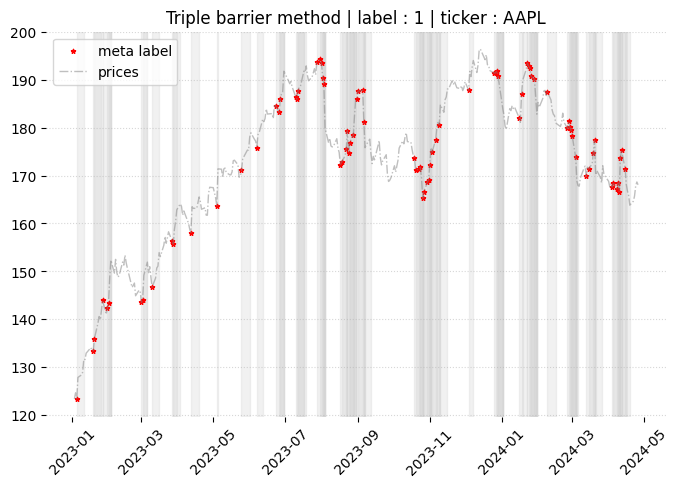

In [16]:
fig, ax = plt.subplots(figsize = (8, 5))
for idx in meta_labels[meta_labels['bin'] == 1]['2023':].index :
    ax.axvspan(
        idx, 
        triple_barrier_events.loc[idx]['t1'], 
        color = 'lightgray', 
        alpha = 0.3
    )
ax.scatter(
    meta_labels[meta_labels['bin'] == 1]['2023':].index,
    data.loc[meta_labels[meta_labels['bin'] == 1].index]['2023':]['Close'],
    marker = '*',
    color = 'red',
    s = 10,
    label = 'meta label'
)
ax.plot(
    data['2023':]['Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
ax.legend()
plt.title('Triple barrier method | label : 1 | ticker : AAPL')
plt.show()

### How to use Meta Labeling

The binary classification problem is a trade-off between type 1 error (false positive) and type 2 error (false negative). Usually, as you increase the true positive rate of a binary classifier, the false positive rate increases. The ROC (Receiver Operating Curve) of a classification model measures the cost incurred as the true positive rate increases, and is measured from the perspective of accepting a high false positive rate.

The picture below visualizes the so-called Confusion matrix. Among the set of observations, there are items that meet the conditions and items that do not meet the conditions. The binary classifier predicts whether a specific item shows a condition (ellipse), and the TP area contains true positives, and the TN area contains true negatives. This causes two types of errors: false positives and false negatives. **precision** is the ratio between the TP area and the oval area, and **recall** is the ratio between the TP area and the left square area. The recall rate of this concept in classification problems is similar to the verification power in hypothesis testing. **accuracy** is the sum of the TP and TN areas divided by the total items. 

Typically, decreasing the FP area increases the FN area, because higher precision generally means fewer predictions, which lowers the **recall rate**. Meanwhile, there is also a combination between precision and recall that maximizes the overall efficiency of the classifier. **f1-score** measures the efficiency of the classifier, using the harmonic mean between precision and recall.

<img src="https://lh3.googleusercontent.com/a34GCCUUjiJDedpXXfJqEUGDFe978H1qkz0qMiqsz4G5Uk njGgPy3px8PNlLnhbT_N9URPFn526aKWjGvzjh8Z9Wb-xHHTYlS_GhbeJO5w-3JHwY5aKMpQMqiQ7EngFhHg" width="200px" height="100px" title="F1 score"/>

Meta Labeling is especially useful when you want a higher F1 score. The reasons are as follows

1. Even though the precision is not very high, it is possible to build a model with a high recall rate.
2. Low precision can be corrected by applying meta labeling to the positives predicted in the primary model.

Using Meta Labeling will improve the F1 score by filtering out false positives, and most positives have already been identified by the primary model. In other words, the role of the Meta Model is to determine whether the positivity determined by the Primary Model is true or false. In other words, the purpose is not to measure betting opportunities, but to decide whether or not to execute a proposed bet.

The reason Meta Labeling is a powerful tool is for the following reasons.

1. Machine learning algorithms are often attacked for being black boxes. Meta Labeling can build a machine learning system on a white box. Meta Labeling models, which have the ability to convert fundamental models into machine learning models, are especially useful in quantitative companies.
2. Applying Meta Labeling suppresses the overfitting effect. This is because Machine Learning does not determine the direction of the bet, but only the size.
3. Meta Labeling enables sophisticated strategy structures by separating bet size prediction and betting direction prediction. For example, it must be taken into account that the characteristics that lead a rally are different from those that lead a plunge. In this case, you can develop a machine learning strategy that considers only the buy position based on the primary model's buy recommendation, or you can develop a machine learning strategy that only considers the sell position based on the sell recommendation of a completely different primary model. 
4. Having high accuracy for small bets or low accuracy for large bets is a recipe for ruin. Just as important as holding your breath is setting an appropriate bet size. Therefore, it becomes quite reasonable to focus on developing machine learning algorithms that accurately make critical decisions. We will look at this fourth point again in Chapter 10.

In the author's (Prado) experience, the Meta Labeling machine learning model provides more robust and reliable results than the standard labeling model.